In [10]:
import sys
import os
import requests
import datetime
import json
import pandas
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics

In [2]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)
username = "rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_rknop_passwd" ) ) as ifp:
    password = ifp.readline().strip()

In [3]:
rqs = requests.session()
rqs.get( f'{url}/accounts/login/' )
res = rqs.post( f'{url}/accounts/login/',
                data={ "username": username,
                       "password": password,
                       "csrfmiddlewaretoken": rqs.cookies['csrftoken'] } )
if res.status_code != 200:
    raise RuntimeError( f"Failed to log in; http status: {res.status_code}" )
if 'Please enter a correct' in res.text:
    raise RuntimeError( "Failed to log in.  I think.  Put in a debug break and look at res.text" )
rqs.headers.update( { 'X-CSRFToken': rqs.cookies['csrftoken'] } )

In [4]:
def run_query(query, subdict=None):
    result = rqs.post( f'{url}/db/runsqlquery/',
        json={ 'query': query, 'subdict': subdict } )
    if result.status_code != 200:
        sys.stderr.write( f"ERROR: got status code {result.status_code} ({result.reason})\n" )
    else:
        data = json.loads( result.text )
        if ( 'status' not in data ) or ( data['status'] != 'ok' ):
            sys.stderr.write( "Got unexpected response\n" )
            print(data['error'])
        else:
            return data['rows']

In [14]:
rows = run_query( 'SELECT "classifierId","brokerName","brokerVersion",'
                  '"classifierName","classifierParams" '
                  'FROM elasticc_brokerclassifier' )
classifier_info = {}
for row in rows:
    classifier_info[row["classifierId"]] = row                                 

In [19]:
rows = run_query( 'SELECT DISTINCT ON ("classId") "classId",description '
                  'FROM elasticc_gentypeofclassid '
                  'ORDER BY "classId"' )
classname = {}
for row in rows:
    classname[row["classId"]] = row["description"]

In [23]:
# This query gets the single highest-probability classification for each object
# from each classifier from all brokers.
# It might also be worth thinking about the latest classification, or other ways
# of selecting the "classifier's answer" for each object.

sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT DISTINCT ON ("classifierId","diaObjectId") '
          '  "classifierId","classId","trueClassId" '
          'FROM elasticc_view_sourceclassifications '
          'ORDER BY "classifierId","diaObjectId","probability" DESC' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
classifiers = data.classifierId.unique()

Query start at 2022-08-19T11:07:31.361304...
Query done at 2022-08-19T11:09:21.993299


41

In [24]:
data = pandas.DataFrame( rows )
classifiers = data.classifierId.unique()

Generating plot for ANTARES / v2.0.6 / LightGBM_test / v0
Generating plot for ANTARES / v2.0.6 / astrorapid / known_redshift=True
Generating plot for ANTARES / 2.0.0 / LiCuParsnip / v1
Generating plot for Fink / 2.2 / rf_snia_vs_nonia_2.0.0 / Probability to be an early SNe Ia based on Random Forest classifier
Generating plot for Fink / 2.2 / snn_snia_vs_nonia_2.0.0 / Probability to be a SN Ia based on SuperNNova classifier
Generating plot for Fink / 2.2 / snn_sn_vs_all_2.0.0 / Probability to be a SN based on SuperNNova classifier


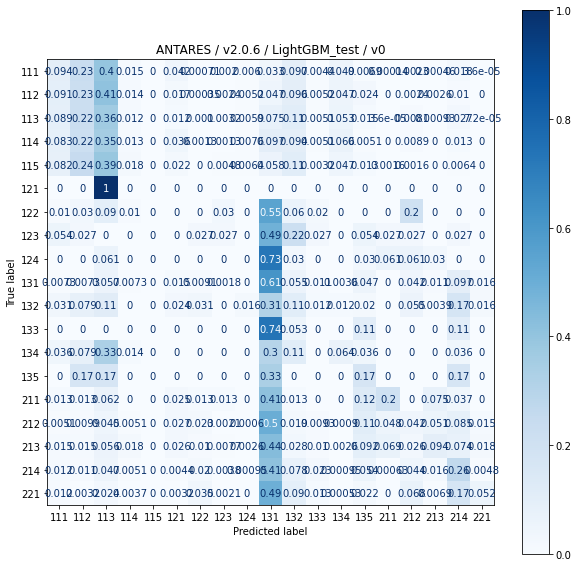

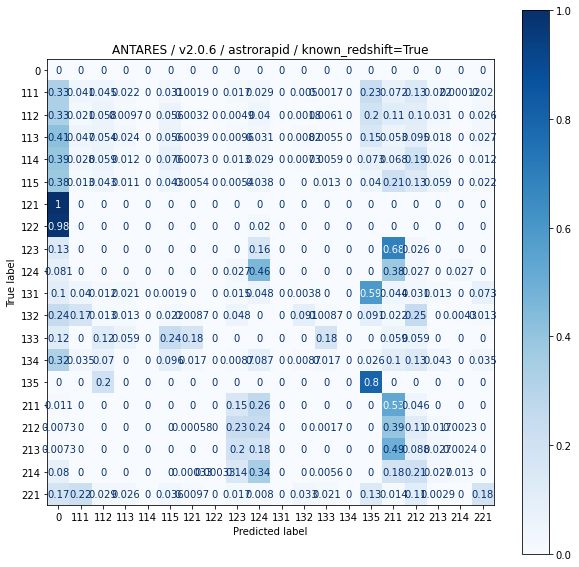

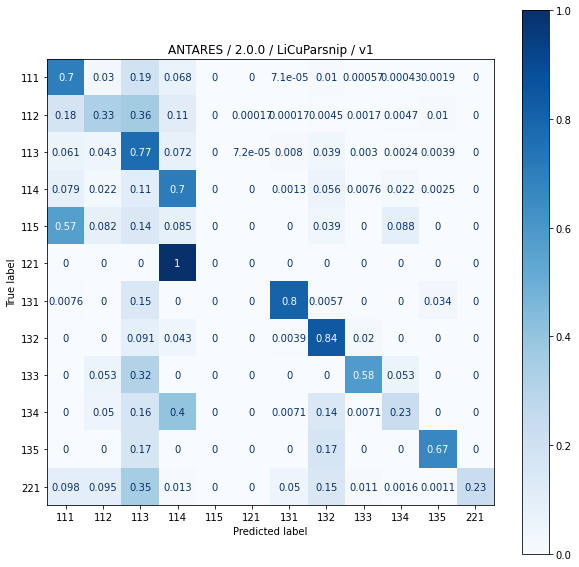

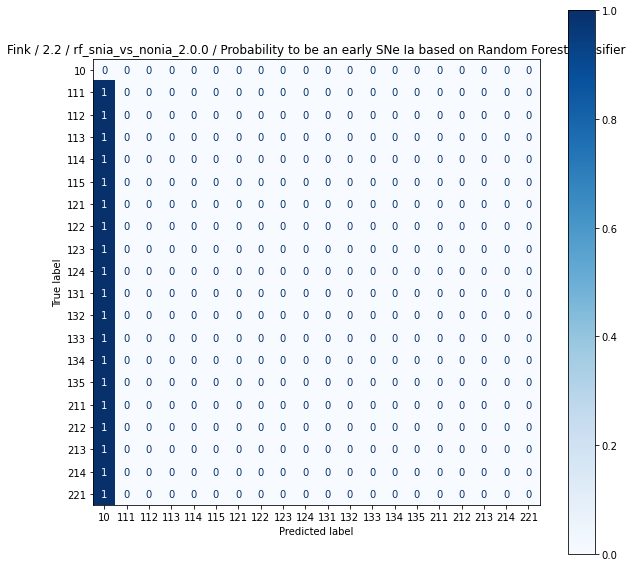

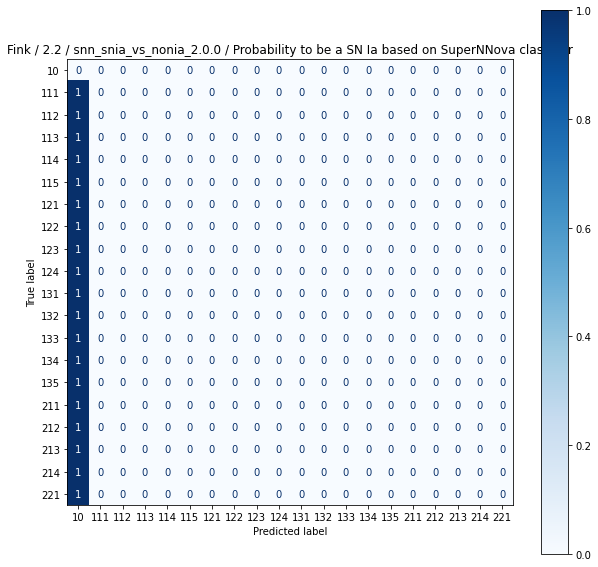

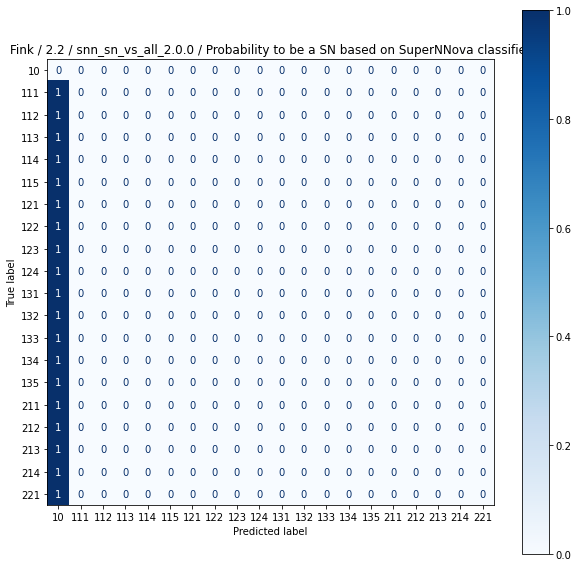

In [26]:
for c in classifiers:
    brokerName = classifier_info[c]['brokerName']
    brokerVersion = classifier_info[c]['brokerVersion']
    classifierName = classifier_info[c]['classifierName']
    classifierParams = classifier_info[c]['classifierParams']
    
    sys.stderr.write( f"Generating plot for {brokerName} / {brokerVersion} "
                      f"/ {classifierName} / {classifierParams}\n" )
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(data[data.classifierId==c].trueClassId,
                                                            data[data.classifierId==c].classId,
                                                            normalize='true',
                                                            # display_labels=names,
                                                            cmap='Blues',
                                                            ax=ax)
    ax.set_title( f'{brokerName} / {brokerVersion} / {classifierName} / {classifierParams}' )
    
# Work is needed on number formatting to keep the confusion
# matrix from having so much confusion